In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import os

In [2]:
PATH_ROOT = Path(os.getcwd()).parents[1].resolve()

PATH_COMBINED  = PATH_ROOT / 'data' / 'datasets' / 'combined_dataset.csv'
PATH_STS  = PATH_ROOT / 'data' / 'datasets' / 'sts.csv'
PATH_QQP  = PATH_ROOT / 'data' / 'datasets' / 'qqp.csv'

In [5]:
cd {PATH_ROOT}

/home/shaul/workspace/GitHub/SOTA


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import glob
import tqdm
from scipy.stats import pearsonr as pcorr
import itertools
import re
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from ipywidgets import interact
from src import metric_exploration

In [8]:
df = pd.read_csv(PATH_COMBINED, index_col= 0)

df.dropna(inplace=True)

with open(PATH_ROOT / 'data'/'bad_annotators' / 'ba_all.txt','r+') as f:
    list_ba = f.read().splitlines() 
df_filtered = df[~df.annotator.isin(list_ba)]

In [9]:
non_metric_columns = ['text1','text2','label','dataset','random','duration','total_seconds','pair_id','reduced_label','annotator','radical','radical_random','radical_non_random','radical_or_centralist','num_labels','bad_annotator']
categories = ['dataset', 'random'] #['radical_or_centralist']

metrics = [x for x in df.columns if x not in non_metric_columns]
all_labels = metrics + ['label'] + ['reduced_label']

In [7]:
datasets_not_ivan = ['bible_random_human','paralex_random_human','paraphrase_random_human']
datasets_with_ivan = [column for column in df.dataset.unique() if column not in datasets_not_ivan]

In [8]:
non_random_columns = [column for column in df.dataset.unique() if ("random" not in column)]

In [9]:
df_ivan = df[df['dataset'].isin(datasets_with_ivan)]

## Rank-induced Orders

In [10]:
rank_induced_base = df.groupby('dataset')[all_labels].mean().rank(ascending=False).T
rank_induced_filt = df_filtered.groupby('dataset')[all_labels].mean().rank(ascending=False).T

In [33]:
rank_induced_base

dataset          bible_human  bible_random_human  gyafc_formal_human  \
bleu                     1.0                10.0                 2.0   
bleu1                    1.0                 9.0                 2.0   
glove_cosine            14.0                 8.0                13.0   
fasttext_cosine         14.0                 8.0                13.0   
BertScore                2.0                13.0                 1.0   
chrfScore                1.0                 8.0                 3.0   
POS Dist score          10.0                 1.0                12.0   
1-gram_overlap           2.0                 9.0                 1.0   
ROUGE-1                  1.0                 9.0                 2.0   
ROUGE-2                  3.0                 9.0                 1.0   
ROUGE-l                  2.0                 9.0                 1.0   
L2_score                14.0                 7.0                13.0   
WMD                     12.0                 6.0                14.0   
label                    4.0                 8.0                 2.0   
reduced_label            4.0                 8.0                 3.0   

dataset          gyafc_formal_random_human  gyafc_informal_human  \
bleu                                   9.0                   5.0   
bleu1                                 10.0                   7.0   
glove_cosine                           7.0                   9.0   
fasttext_cosine                        7.0                   9.0   
BertScore                             10.0                   7.0   
chrfScore                             10.0                   7.0   
POS Dist score                         5.0                   7.0   
1-gram_overlap                        10.0                   6.0   
ROUGE-1                               10.0                   6.0   
ROUGE-2                               11.0                   6.0   
ROUGE-l                               10.0                   7.0   
L2_score                               6.0                  10.0   
WMD                                    7.0                   8.0   
label                                 11.0                   5.0   
reduced_label                         11.0                   5.0   

dataset          gyafc_informal_random_human  gyafc_rewrites_human  \
bleu                                     8.0                   3.0   
bleu1                                   13.0                   3.0   
glove_cosine                             5.0                  12.0   
fasttext_cosine                          5.0                  12.0   
BertScore                               14.0                   4.0   
chrfScore                               13.0                   2.0   
POS Dist score                           4.0                  11.0   
1-gram_overlap                          13.0                   3.0   
ROUGE-1                                 12.0                   3.0   
ROUGE-2                                 10.0                   2.0   
ROUGE-l                                 12.0                   3.0   
L2_score                                 5.0                  12.0   
WMD                                      3.0                  11.0   
label                                   10.0                   1.0   
reduced_label                           10.0                   1.0   

dataset          gyafc_rewrites_random_human  paralex_human  \
bleu                                    12.0            6.0   
bleu1                                   12.0            5.0   
glove_cosine                             6.0           10.0   
fasttext_cosine                          6.0           11.0   
BertScore                               12.0            6.0   
chrfScore                               12.0            5.0   
POS Dist score                           3.0            8.0   
1-gram_overlap                          12.0            5.0   
ROUGE-1                                 13.0            5.0   
ROUGE-2

In [12]:
rank_induced_filt

dataset          bible_human  bible_random_human  gyafc_formal_human  \
bleu                     2.0                10.0                 1.0   
bleu1                    1.0                 9.0                 2.0   
glove_cosine            14.0                 8.0                13.0   
fasttext_cosine         14.0                 8.0                13.0   
BertScore                2.0                13.0                 1.0   
chrfScore                1.0                 8.0                 3.0   
POS Dist score          11.0                 1.0                12.0   
1-gram_overlap           3.0                 9.0                 1.0   
ROUGE-1                  1.0                 9.0                 2.0   
ROUGE-2                  3.0                 9.0                 1.0   
ROUGE-l                  2.0                 9.0                 1.0   
L2_score                14.0                 7.0                13.0   
WMD                     13.0                 6.0                14.0   
label                    5.0                 9.0                 2.0   
reduced_label            5.0                12.0                 2.0   

dataset          gyafc_formal_random_human  gyafc_informal_human  \
bleu                                   9.0                   5.0   
bleu1                                 10.0                   7.0   
glove_cosine                           7.0                   9.0   
fasttext_cosine                        7.0                   9.0   
BertScore                             10.0                   7.0   
chrfScore                             10.0                   7.0   
POS Dist score                         5.0                   7.0   
1-gram_overlap                        10.0                   6.0   
ROUGE-1                               10.0                   7.0   
ROUGE-2                               10.0                   6.0   
ROUGE-l                               10.0                   7.0   
L2_score                               6.0                  10.0   
WMD                                    7.0                   8.0   
label                                 14.0                   4.0   
reduced_label                         14.0                   4.0   

dataset          gyafc_informal_random_human  gyafc_rewrites_human  \
bleu                                     8.0                   3.0   
bleu1                                   13.0                   3.0   
glove_cosine                             5.0                  12.0   
fasttext_cosine                          5.0                  12.0   
BertScore                               14.0                   4.0   
chrfScore                               13.0                   2.0   
POS Dist score                           3.0                  10.0   
1-gram_overlap                          13.0                   2.0   
ROUGE-1                                 11.0                   3.0   
ROUGE-2                                 11.0                   2.0   
ROUGE-l                                 11.0                   3.0   
L2_score                                 5.0                  12.0   
WMD                                      3.0                  12.0   
label                                    8.0                   1.0   
reduced_label                            8.0                   1.0   

dataset          gyafc_rewrites_random_human  paralex_human  \
bleu                                    12.0            6.0   
bleu1                                   12.0            5.0   
glove_cosine                             6.0           10.0   
fasttext_cosine                          6.0           11.0   
BertScore                               12.0            6.0   
chrfScore                               12.0            5.0   
POS Dist score                           4.0            9.0   
1-gram_overlap                          12.0            5.0   
ROUGE-1                                 13.0            4.0   
ROUGE-2

In [13]:
rank_induced_base.T[metrics].corrwith(rank_induced_base.T['label']).sort_values(ascending=False)

chrfScore          0.837363
bleu               0.832967
ROUGE-l            0.824176
ROUGE-2            0.815385
ROUGE-1            0.806593
1-gram_overlap     0.806593
bleu1              0.806593
BertScore          0.736264
glove_cosine      -0.665934
fasttext_cosine   -0.670330
POS Dist score    -0.679121
WMD               -0.850549
L2_score          -0.859341
dtype: float64

In [14]:
rank_induced_filt.T[metrics].corrwith(rank_induced_filt.T['label']).sort_values(ascending=False)

bleu               0.819780
ROUGE-2            0.784615
ROUGE-l            0.767033
ROUGE-1            0.758242
1-gram_overlap     0.758242
chrfScore          0.753846
bleu1              0.731868
BertScore          0.670330
glove_cosine      -0.595604
fasttext_cosine   -0.600000
POS Dist score    -0.652747
WMD               -0.789011
L2_score          -0.810989
dtype: float64

## Correlation Metrics

In [15]:
mc = metric_exploration.Metrics_Corr(df_ivan,non_metric_columns,categories)
base_results = mc.get_corr(None)
filtered_results = mc.get_corr(list_ba)

In [16]:
@interact
def display_corr(key_v = base_results.keys()):
     if type(base_results[key_v]) ==  pd.Series:
          display(base_results[key_v].sort_values(ascending=False))
     else:
          display(base_results[key_v])

interactive(children=(Dropdown(description='key_v', options=('label_by_dataset', 'reduced_label_by_dataset', '…

In [17]:
@interact
def display_corr(key_v = filtered_results.keys()):
     if type(filtered_results[key_v]) ==  pd.Series:
          display(filtered_results[key_v].sort_values(ascending=False))
     else:
          display(filtered_results[key_v])

interactive(children=(Dropdown(description='key_v', options=('label_by_dataset', 'reduced_label_by_dataset', '…

In [18]:
result = mc.compare_correlations(list_ba)

In [19]:
@interact
def display_corr(key_v = result.keys()):
     if type(result[key_v]) ==  pd.Series:
          display(result[key_v].sort_values(ascending=False))
     else:
          display(result[key_v])

interactive(children=(Dropdown(description='key_v', options=('label_by_dataset', 'reduced_label_by_dataset', '…

## Look at the Non-Linear and Linear Models

In [20]:
mm = metric_exploration.Metrics_Models(df,non_metric_columns,categories)
loss, fi_values = mm.run_model(model_type = "RF")

In [21]:
metric_exploration.visualize_fi(fi_values, categories)

interactive(children=(Dropdown(description='key_v', options=('fi_label_by_dataset_bible_human', 'fi_reduced_la…

interactive(children=(Dropdown(description='key_v', options=('fi_label_by_random_0', 'fi_reduced_label_by_rand…

interactive(children=(Dropdown(description='key_v', options=('fi_label_combined', 'fi_reduced_label_combined')…

In [22]:
metric_exploration.visualize_loss(loss, "RF Scores")

In [23]:
loss2 = mm.run_model(model_type="MLP")
metric_exploration.visualize_loss(loss2, "MSE for MLP")

In [24]:
mm_filt = metric_exploration.Metrics_Models(df_filtered,non_metric_columns,categories)
loss, fi_values = mm_filt.run_model(model_type = "RF")

In [25]:
metric_exploration.visualize_fi(fi_values, categories)

interactive(children=(Dropdown(description='key_v', options=('fi_label_by_dataset_bible_human', 'fi_reduced_la…

interactive(children=(Dropdown(description='key_v', options=('fi_label_by_random_0', 'fi_reduced_label_by_rand…

interactive(children=(Dropdown(description='key_v', options=('fi_label_combined', 'fi_reduced_label_combined')…

In [26]:
metric_exploration.visualize_loss(loss, "RF Scores")

In [27]:
loss2 = mm_filt.run_model(model_type="MLP")
metric_exploration.visualize_loss(loss2, "MSE for MLP")

# See How the model gets better with the filtered dataset

In [28]:
import importlib
importlib.reload(metric_exploration)

<module 'src.metric_exploration' from '/home/shaul/workspace/GitHub/SOTA/src/metric_exploration.py'>

In [29]:
comb_scores = mm.compare_score(list_ba, "RF")
metric_exploration.visualize_score(comb_scores, "Improvement of filtered dataset - RF")

In [30]:
comb_scores = mm.compare_score(list_ba, "MLP")
metric_exploration.visualize_score(comb_scores, "Improvement of filtered dataset - MLP")

### NO MANS LAND

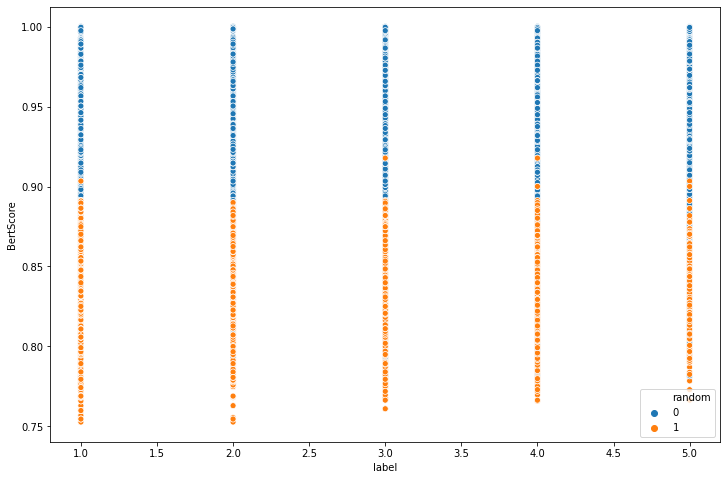

In [31]:
plt.figure(figsize=(12,8))
sns.scatterplot(df['label'],df['BertScore'],hue=df['random']);